In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from IPython.display import display
from ipywidgets import interact, interact_manual
import re

In [2]:
df = pd.read_csv("insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [4]:
df.describe(include = object)

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
df.shape

(1338, 7)

In [7]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

# EDA

In [8]:
df.groupby('sex')['charges'].agg({'mean','median','min','max'})

,min,max,median,mean
sex,,,,
female,1607.5101,63770.42801,9412.96250,12569.578844
male,1121.8739,62592.87309,9369.61575,13956.751178


In [9]:
df.var()

C:\Users\yousu\AppData\Local\Temp\ipykernel_13180\1568254755.py:1: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.var()


age         1.974014e+02
bmi         3.718788e+01
children    1.453213e+00
charges     1.466524e+08
dtype: float64

In [10]:
df.mad()

C:\Users\yousu\AppData\Local\Temp\ipykernel_13180\3844944795.py:1: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  df.mad()


age           12.248931
bmi            4.897871
children       0.985405
charges     9091.126581
dtype: float64

In [11]:
print('length :',len(df.loc[(df['age'] == 0) | (df['bmi'] == 0) | (df['children'] == 0) | (df['charges'] == 0)]))

length : 574


In [12]:
zero_columns = []

if (df['age'] == 0).any():
    zero_columns.append(('age', (df['age'] == 0).sum()))
if (df['bmi'] == 0).any():
    zero_columns.append(('bmi', (df['bmi'] == 0).sum()))
if (df['children'] == 0).any():
    zero_columns.append(('children', (df['children'] == 0).sum()))
if (df['charges'] == 0).any():
    zero_columns.append(('charges', (df['charges'] == 0).sum()))

for column, count in zero_columns:
    print(f"Columns with 0 values: {column} has {count} zero values")

Columns with 0 values: children has 574 zero values


In [13]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [14]:
df.skew()

C:\Users\yousu\AppData\Local\Temp\ipykernel_13180\1665899112.py:1: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.skew()


age         0.055673
bmi         0.284047
children    0.938380
charges     1.515880
dtype: float64

- <b>age :        0.055673</b> (in between -0.5 to 0.5, its symmetric skewness, outliers are not impacted outliers)
- <b>bmi :        0.284047</b> (in between -0.5 to 0.5, its symmetric skewness, outliers are not impacted outliers)
- <b>children :   0.938380</b> (greater then 0.5, positive skewness, outliers are much impacted outliers)
- <b>charges  :   1.515880</b> (greater then 0.5, positive skewness, outliers are much impacted outliers)

In [15]:
@interact_manual
def groupby(col = df.select_dtypes('number').columns):
           
    sns.boxplot(df[col]);

interactive(children=(Dropdown(description='col', options=('age', 'bmi', 'children', 'charges'), value='age'),…

## Finding Lower Bond, Upper Bond and IQR (Inter Quartile Range) For All Columns

In [16]:
def iqr(data,col):
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    lb = q1 - (1.5 * iqr)
    ub = q3 + (1.5 * iqr)
    outliers = list(data[(data[col] < lb) | (data[col] > ub)][col])
    #print(outliers)
    #return len(outliers)
    return 'len of {} column outliers is : {}, percentage of outliers is {}, Lower limit is: {}, Upper limit is: {}'.format(col,len(outliers),(len(outliers)/len(data)),lb,ub)

In [17]:
for col in df.select_dtypes('number').columns:
    #print(col) # printing columns
    
    print(iqr(df,col))

len of age column outliers is : 0, percentage of outliers is 0.0, Lower limit is: -9.0, Upper limit is: 87.0
len of bmi column outliers is : 9, percentage of outliers is 0.006726457399103139, Lower limit is: 13.7, Upper limit is: 47.290000000000006
len of children column outliers is : 0, percentage of outliers is 0.0, Lower limit is: -3.0, Upper limit is: 5.0
len of charges column outliers is : 139, percentage of outliers is 0.1038863976083707, Lower limit is: -13109.1508975, Upper limit is: 34489.350562499996


# Measures of Relation
### Correlation: 
It ranges from -1 to 1
- #### Positive Correlation : 1 indicating a perfect positive correlation
- #### No Correlation : 0 indicating no correlation
- #### Negative Correlation : -1 indicating a perfect negative correlation.

In [18]:
df.corr()

C:\Users\yousu\AppData\Local\Temp\ipykernel_13180\1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


- Correlation between age and children is very weak (0.04)
- The correlation between age and charges is moderately strong (0.299) i.e (30%) as compare to bmi.
- The diagonal values, where each variable is compared to itself, are all 1 as they represent the correlation of the variable with itself which is perfect.

C:\Users\yousu\AppData\Local\Temp\ipykernel_13180\621126171.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True)


<Axes: >

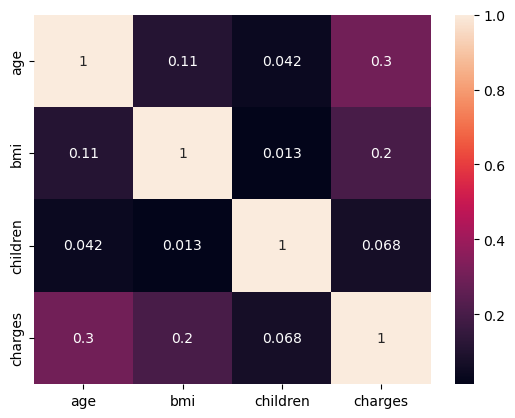

In [19]:
sns.heatmap(df.corr(), annot=True)

In [20]:
@interact_manual
def groupby(col1 = df.select_dtypes('object').columns,
           col2 = df.select_dtypes('object').columns):
    ct = pd.crosstab(df[col1], df[col2], margins=True)
    display(ct)

interactive(children=(Dropdown(description='col1', options=('sex', 'smoker', 'region'), value='sex'), Dropdown…

In [21]:
df_ct = round(pd.crosstab(df['sex'],df['smoker'],margins=True)/len(df),3)
df_ct

smoker,no,yes,All
sex,,,
female,0.409,0.086,0.495
male,0.386,0.119,0.505
All,0.795,0.205,1.000


In [22]:
@interact
def groupby(col1 = df.select_dtypes('object').columns,
           col2 = df.select_dtypes('number').columns):
    return df.groupby(col1)[col2].agg({'min','mean','median','max','count'})

interactive(children=(Dropdown(description='col1', options=('sex', 'smoker', 'region'), value='sex'), Dropdown…

<Axes: xlabel='sex'>

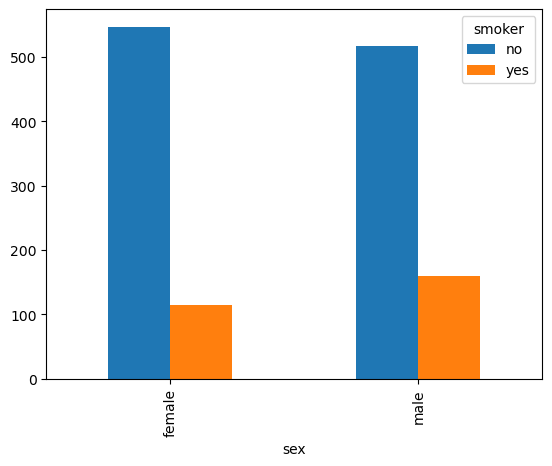

In [23]:
pd.crosstab(df['sex'],df['smoker']).plot.bar()

In [24]:
df['sex'].value_counts()

male      676
female    662
Name: sex, dtype: int64

In [25]:
!pip install -U scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [26]:
import sklearn

## As the objective is to predict the individual medical costs (charges), which is a continuous numerical value. Therefore, the type of machine learning algorithm that would be appropriate for this task is regression analysis.

- ## Input = age, sex, bmi, children, smoker and region
- ## Output = Charges

In [27]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [28]:
# Separating Inputs and Outputs
Y=df['charges']
X=df[['age', 'sex', 'bmi', 'children', 'smoker', 'region']]

In [29]:
# split into train and test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.75, random_state=100)

In [30]:
X_train.head()

,age,sex,bmi,children,smoker,region
999,36,female,26.885,0,no,northwest
884,25,male,26.695,4,no,northwest
517,45,male,30.495,2,no,northwest
1132,57,male,40.280,0,no,northeast
1188,43,female,25.270,1,yes,northeast


In [31]:
print(X_train.shape, y_train.shape)

print(X_test.shape, y_test.shape)

(1003, 6) (1003,)
(335, 6) (335,)


# Separating Categorical and Numerical Columns:

In [32]:
X_train.head()

,age,sex,bmi,children,smoker,region
999,36,female,26.885,0,no,northwest
884,25,male,26.695,4,no,northwest
517,45,male,30.495,2,no,northwest
1132,57,male,40.280,0,no,northeast
1188,43,female,25.270,1,yes,northeast


In [33]:
X_train.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
dtype: object

In [34]:
X_train_cat = X_train.select_dtypes(include=['object'])

X_train_cat.head()

,sex,smoker,region
999,female,no,northwest
884,male,no,northwest
517,male,no,northwest
1132,male,no,northeast
1188,female,yes,northeast


In [35]:
X_train_num = X_train.select_dtypes(include=['int64', 'float64'])

X_train_num.head()

,age,bmi,children
999,36,26.885,0
884,25,26.695,4
517,45,30.495,2
1132,57,40.280,0
1188,43,25.270,1


In [36]:
# scaling the numerical features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


X_train_num_rescaled = pd.DataFrame(scaler.fit_transform(X_train_num), 
                                    columns = X_train_num.columns, 
                                    index = X_train_num.index)

X_train_num_rescaled.head()

,age,bmi,children
999,-0.213395,-0.612676,-0.920408
884,-0.995845,-0.643146,2.430478
517,0.426791,-0.033747,0.755035
1132,1.280372,1.535457,-0.920408
1188,0.284527,-0.871671,-0.082686


In [37]:
X_train_num.describe()

,age,bmi,children
count,1003.00000,1003.000000,1003.000000
mean,39.00000,30.705434,1.098704
std,14.06543,6.238758,1.194310
min,18.00000,15.960000,0.000000
25%,26.00000,26.125000,0.000000
50%,39.00000,30.400000,1.000000
75%,51.00000,34.960000,2.000000
max,64.00000,53.130000,5.000000


In [38]:
print("Number of Numerical Features:", scaler.n_features_in_)
print("Mean of each column:", scaler.mean_)
print("Std of each column:", np.sqrt(scaler.var_))

Number of Numerical Features: 3
Mean of each column: [39.         30.7054337   1.09870389]
Std of each column: [14.05841679  6.23564757  1.19371414]


# Applying OneHotEncoding on Categorical Columns

In [39]:
X_train_cat['sex'].value_counts(normalize=True)

female    0.50349
male      0.49651
Name: sex, dtype: float64

In [40]:
X_train_cat['smoker'].value_counts(normalize=True)

no     0.803589
yes    0.196411
Name: smoker, dtype: float64

In [41]:
X_train_cat['region'].value_counts(normalize=True)

southeast    0.280160
northwest    0.247258
southwest    0.241276
northeast    0.231306
Name: region, dtype: float64

In [42]:
X_train_cat

,sex,smoker,region
999,female,no,northwest
884,male,no,northwest
517,male,no,northwest
1132,male,no,northeast
1188,female,yes,northeast
...,...,...,...
802,male,no,southwest
53,male,yes,southeast
350,female,no,northwest
79,female,no,northwest


In [43]:
X_train_cat.columns

Index(['sex', 'smoker', 'region'], dtype='object')

In [44]:
# OneHotEncoding the categorical features

from sklearn.preprocessing import OneHotEncoder

encoder_ = OneHotEncoder(min_frequency=3000, sparse=False)


X_train_cat_ohe = pd.DataFrame(encoder_.fit_transform(X_train_cat), 
                               columns=encoder_.get_feature_names_out(X_train_cat.columns), 
                               index = X_train_cat.index)

X_train_cat_ohe.head()

C:\Users\yousu\AppData\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,sex_infrequent_sklearn,smoker_infrequent_sklearn,region_infrequent_sklearn
999,1.0,1.0,1.0
884,1.0,1.0,1.0
517,1.0,1.0,1.0
1132,1.0,1.0,1.0
1188,1.0,1.0,1.0


In [45]:
encoder_.categories_

[array(['female', 'male'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['northeast', 'northwest', 'southeast', 'southwest'], dtype=object)]

In [46]:
encoder_.infrequent_categories_

[array(['female', 'male'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['northeast', 'northwest', 'southeast', 'southwest'], dtype=object)]

In [47]:
# OneHotEncoding the categorical features

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)


X_train_cat_ohe = pd.DataFrame(encoder.fit_transform(X_train_cat), 
                               columns=encoder.get_feature_names_out(X_train_cat.columns), 
                               index = X_train_cat.index)

X_train_cat_ohe.head()

C:\Users\yousu\AppData\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
999,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
884,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
517,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1132,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
1188,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


# Applying Label Encoding on Categorical Columns

In [48]:
X_train_cat_le = pd.DataFrame(index=X_train_cat.index)

X_train_cat_le.head()

""
999
884
517
1132
1188


In [49]:
X_train_cat.sex.unique()

array(['female', 'male'], dtype=object)

In [50]:
sex_encoder = {'female' : 1, 'male' : 2}

X_train_cat_le['sex'] = X_train_cat['sex'].apply(lambda x : sex_encoder[x])

X_train_cat_le.head()

,sex
999,1
884,2
517,2
1132,2
1188,1


In [51]:
X_train_cat.smoker.unique()

array(['no', 'yes'], dtype=object)

In [52]:
smoker_encoder = {'yes' : 1, 'no' : 2}

X_train_cat_le['smoker'] = X_train_cat['smoker'].apply(lambda x : smoker_encoder[x])

X_train_cat_le.head()

,sex,smoker
999,1,2
884,2,2
517,2,2
1132,2,2
1188,1,1


In [53]:
X_train_cat.region.unique()

array(['northwest', 'northeast', 'southeast', 'southwest'], dtype=object)

In [54]:
region_encoder = {'northwest' : 1, 'northeast' : 2, 'southeast':3, 'southwest':4}

X_train_cat_le['region'] = X_train_cat['region'].apply(lambda x : region_encoder[x])

X_train_cat_le.head()

,sex,smoker,region
999,1,2,1
884,2,2,1
517,2,2,1
1132,2,2,2
1188,1,1,2


# Concatinating the Encoded Categorical Features and Rescaled Numerical Features:

In [55]:
X_train_transformed = pd.concat([X_train_num_rescaled, X_train_cat_le], axis=1)

X_train_transformed.head()

,age,bmi,children,sex,smoker,region
999,-0.213395,-0.612676,-0.920408,1,2,1
884,-0.995845,-0.643146,2.430478,2,2,1
517,0.426791,-0.033747,0.755035,2,2,1
1132,1.280372,1.535457,-0.920408,2,2,2
1188,0.284527,-0.871671,-0.082686,1,1,2


# Preparing Test Data

In [56]:
X_test.head()

,age,sex,bmi,children,smoker,region
12,23,male,34.400,0,no,southwest
306,28,female,27.500,2,no,southwest
318,44,female,27.645,0,no,northwest
815,20,female,31.460,0,no,southeast
157,18,male,25.175,0,yes,northeast


In [57]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 335 entries, 12 to 624
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       335 non-null    int64  
 1   sex       335 non-null    object 
 2   bmi       335 non-null    float64
 3   children  335 non-null    int64  
 4   smoker    335 non-null    object 
 5   region    335 non-null    object 
dtypes: float64(1), int64(2), object(3)
memory usage: 18.3+ KB


In [58]:
X_test_cat = X_test.select_dtypes(include=['object'])

X_test_cat.head()

,sex,smoker,region
12,male,no,southwest
306,female,no,southwest
318,female,no,northwest
815,female,no,southeast
157,male,yes,northeast


In [59]:
X_test_num = X_test.select_dtypes(include=['int64', 'float64'])

X_test_num.head()

,age,bmi,children
12,23,34.400,0
306,28,27.500,2
318,44,27.645,0
815,20,31.460,0
157,18,25.175,0


In [60]:
X_test_num_rescaled = pd.DataFrame(scaler.transform(X_test_num), 
                                   columns = X_test_num.columns, 
                                   index = X_test_num.index)

X_test_num_rescaled.head()

,age,bmi,children
12,-1.138108,0.592491,-0.920408
306,-0.782449,-0.514050,0.755035
318,0.355659,-0.490796,-0.920408
815,-1.351504,0.121008,-0.920408
157,-1.493767,-0.886906,-0.920408


In [61]:
X_test_cat_le = pd.DataFrame(index = X_test_cat.index)

X_test_cat_le.head()

""
12
306
318
815
157


In [62]:
X_test_cat_le['sex'] = X_test_cat['sex'].apply(lambda x : sex_encoder[x])

X_test_cat_le['smoker'] = X_test_cat['smoker'].apply(lambda x : smoker_encoder[x])

X_test_cat_le['region'] = X_test_cat['region'].apply(lambda x : region_encoder[x])

X_test_cat_le.head()

,sex,smoker,region
12,2,2,4
306,1,2,4
318,1,2,1
815,1,2,3
157,2,1,2


In [63]:
X_test_transformed = pd.concat([X_test_num_rescaled, X_test_cat_le], axis=1)

X_test_transformed.head()

,age,bmi,children,sex,smoker,region
12,-1.138108,0.592491,-0.920408,2,2,4
306,-0.782449,-0.514050,0.755035,1,2,4
318,0.355659,-0.490796,-0.920408,1,2,1
815,-1.351504,0.121008,-0.920408,1,2,3
157,-1.493767,-0.886906,-0.920408,2,1,2


# Linear Regression

In [64]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train_transformed, y_train)

LinearRegression()

In [65]:
y_pred_LR = regressor.predict(X_test_transformed)

In [66]:
temp_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_LR})

temp_df.head()

,Actual,Predicted
12,1826.84300,4433.580051
306,20177.67113,4543.146064
318,7421.19455,8706.153454
815,1877.92940,3018.106830
157,15518.18025,24641.404705


<Axes: xlabel='charges', ylabel='Count'>

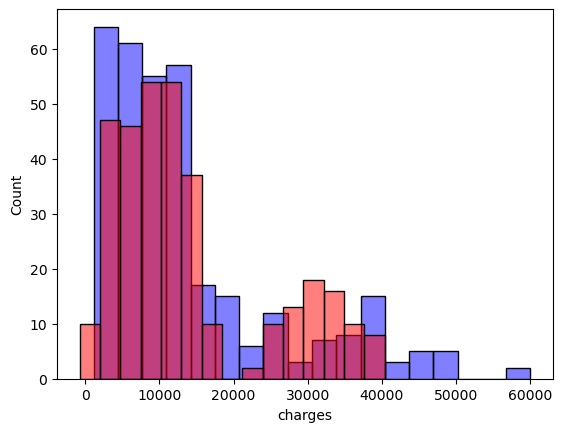

In [67]:
sns.histplot(y_test, color='blue', alpha=0.5)
sns.histplot(y_pred_LR, color='red', alpha=0.5)

In [68]:
from sklearn import metrics

mae_LR = metrics.mean_absolute_error(y_test, y_pred_LR)

print('Mean Absolute Error: ', mae_LR)

print('Mean Squared Error: ', metrics.mean_squared_error(y_test, y_pred_LR))

print('Root Mean Squared Error: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred_LR)))

Mean Absolute Error:  3919.187115343998
Mean Squared Error:  32168554.63388656
Root Mean Squared Error:  5671.732948040357


## KNN Regression

In [69]:
from sklearn.neighbors import KNeighborsRegressor
regressor = KNeighborsRegressor()
regressor.fit(X_train_transformed, y_train)

KNeighborsRegressor()

In [70]:
y_pred_KNN = regressor.predict(X_test_transformed)

In [71]:
temp_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_KNN})

temp_df.head()

,Actual,Predicted
12,1826.84300,5709.030466
306,20177.67113,5171.983000
318,7421.19455,6442.799240
815,1877.92940,3752.705570
157,15518.18025,20545.713086


<Axes: xlabel='charges', ylabel='Count'>

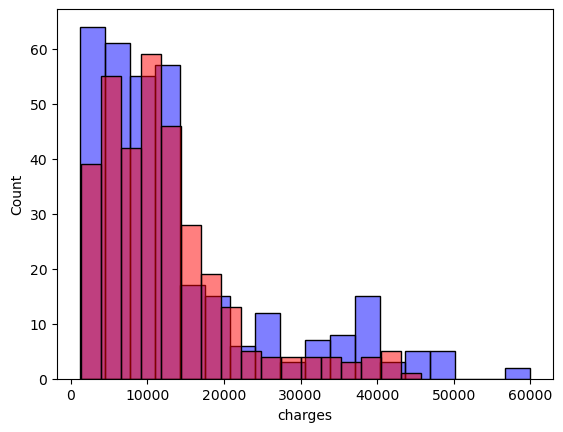

In [72]:
sns.histplot(y_test, color='blue', alpha=0.5)
sns.histplot(y_pred_KNN, color='red', alpha=0.5)

In [73]:
mae_KNN = metrics.mean_absolute_error(y_test, y_pred_KNN)


print('Mean Absolute Error: ', mae_KNN)

print('Mean Squared Error: ', metrics.mean_squared_error(y_test, y_pred_KNN))

print('Root Mean Squared Error: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred_KNN)))

Mean Absolute Error:  4199.774397161194
Mean Squared Error:  48031452.82882389
Root Mean Squared Error:  6930.472770945997


# Decision Tree Regression

In [74]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor()
regressor.fit(X_train_transformed, y_train)

DecisionTreeRegressor()

In [75]:
y_pred_DT = regressor.predict(X_test_transformed)

temp_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_DT})

temp_df.head()

,Actual,Predicted
12,1826.84300,1837.2819
306,20177.67113,4340.4409
318,7421.19455,7419.4779
815,1877.92940,1622.1885
157,15518.18025,16450.8947


<Axes: xlabel='charges', ylabel='Count'>

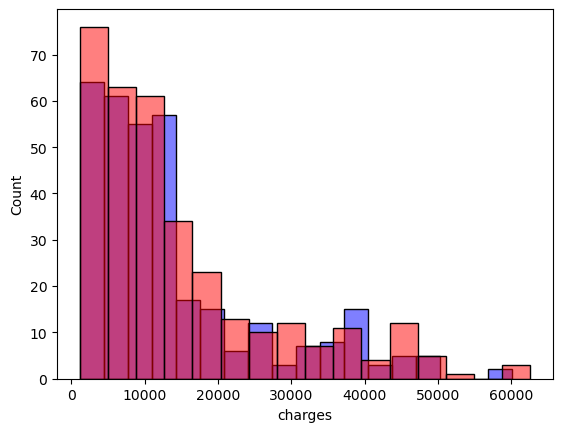

In [76]:
sns.histplot(y_test, color='blue', alpha=0.5)
sns.histplot(y_pred_DT, color='red', alpha=0.5)

In [77]:
mae_DT = metrics.mean_absolute_error(y_test, y_pred_DT)

print('Mean Absolute Error: ', mae_DT)

print('Mean Squared Error: ', metrics.mean_squared_error(y_test, y_pred_DT))

print('Root Mean Squared Error: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred_DT)))

Mean Absolute Error:  3227.471423922389
Mean Squared Error:  44722709.60501029
Root Mean Squared Error:  6687.503989158458


# Random Forest Regression

In [78]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor()
regressor.fit(X_train_transformed, y_train)

RandomForestRegressor()

In [79]:
y_pred_RF = regressor.predict(X_test_transformed)


temp_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_RF})

temp_df.head()

,Actual,Predicted
12,1826.84300,4451.106440
306,20177.67113,4410.646839
318,7421.19455,12780.239067
815,1877.92940,2186.447857
157,15518.18025,16668.253558


<Axes: xlabel='charges', ylabel='Count'>

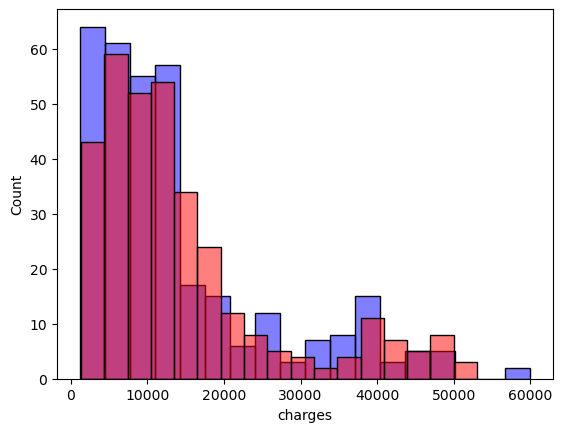

In [80]:
sns.histplot(y_test, color='blue', alpha=0.5)
sns.histplot(y_pred_RF, color='red', alpha=0.5)

In [81]:
mae_RF = metrics.mean_absolute_error(y_test, y_pred_RF)

print('Mean Absolute Error: ', mae_RF)

print('Mean Squared Error: ', metrics.mean_squared_error(y_test, y_pred_RF))

print('Root Mean Squared Error: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred_RF)))

Mean Absolute Error:  2788.1558302008143
Mean Squared Error:  21342229.227238096
Root Mean Squared Error:  4619.765061909328


# Support Vector Regressor

In [82]:
from sklearn.svm import SVR
svrReg = SVR()
svrReg.fit(X_train_transformed,y_train)
y_pred_SVR = svrReg.predict(X_test_transformed)

In [83]:
temp_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_SVR})

temp_df.head()

,Actual,Predicted
12,1826.84300,8955.336822
306,20177.67113,8961.482054
318,7421.19455,9008.557366
815,1877.92940,8931.340192
157,15518.18025,8950.042498


<Axes: xlabel='charges', ylabel='Count'>

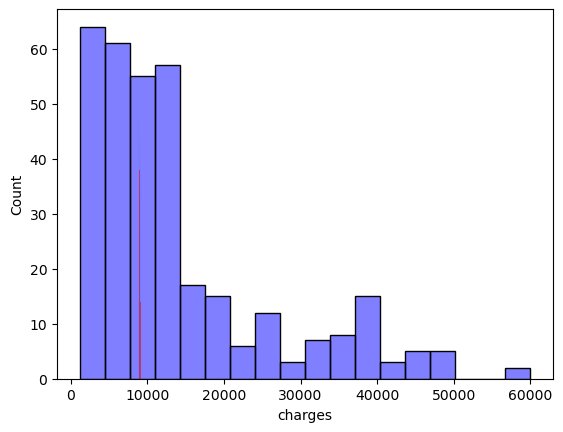

In [84]:
sns.histplot(y_test, color='blue', alpha=0.5)
sns.histplot(y_pred_SVR, color='red', alpha=0.5)

In [85]:
mae_SVR = metrics.mean_absolute_error(y_test, y_pred_SVR)
print('Mean Absolute Error: ', mae_SVR)
print('Mean Squared Error: ', metrics.mean_squared_error(y_test, y_pred_SVR))
print('Root Mean Squared Error: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred_SVR)))

Mean Absolute Error:  8430.445209258822
Mean Squared Error:  170435979.35597512
Root Mean Squared Error:  13055.113149872548


# GBDT Regressor

In [86]:
from sklearn.ensemble import GradientBoostingRegressor
GBDT_reg = GradientBoostingRegressor()
GBDT_reg.fit(X_train_transformed,y_train)
y_pred_GBDT = GBDT_reg.predict(X_test_transformed)

In [87]:
temp_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_GBDT})

temp_df.head()

,Actual,Predicted
12,1826.84300,3793.619697
306,20177.67113,5852.908198
318,7421.19455,10702.348930
815,1877.92940,3162.916441
157,15518.18025,15968.664648


<Axes: xlabel='charges', ylabel='Count'>

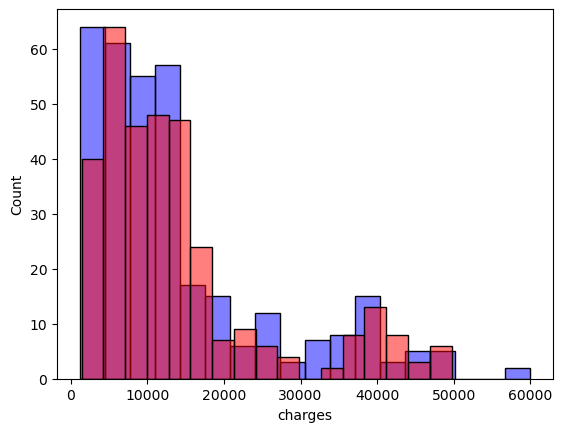

In [88]:
sns.histplot(y_test, color='blue', alpha=0.5)
sns.histplot(y_pred_GBDT, color='red', alpha=0.5)

In [89]:
mae_GBDT = metrics.mean_absolute_error(y_test, y_pred_GBDT)
print('Mean Absolute Error: ', mae_GBDT)
print('Mean Squared Error: ', metrics.mean_squared_error(y_test, y_pred_GBDT))
print('Root Mean Squared Error: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred_GBDT)))

Mean Absolute Error:  2413.4880565444464
Mean Squared Error:  16072845.716216438
Root Mean Squared Error:  4009.0953737989867


#  Evaluation And Comparision

In [90]:
evaluation = pd.DataFrame({'Algorithms':['Linear Regression','KNN','Decision Tree','Random Forest','SVR','GBDT Regressor',] ,
                           'MAE': [mae_LR,mae_KNN,mae_DT,mae_RF,mae_SVR,mae_GBDT]})
evaluation

,Algorithms,MAE
0,Linear Regression,3919.187115
1,KNN,4199.774397
2,Decision Tree,3227.471424
3,Random Forest,2788.155830
4,SVR,8430.445209
5,GBDT Regressor,2413.488057


# Conclusion:
GBDT Regressor algorithm is the best algorithm